## FastMRI Loss & Mask Validation Notebook

1) Common Imports & Settings

In [17]:
import os, sys, glob, warnings
from pathlib import Path
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from loss_function import (
    L1Loss, SSIMLoss, MSSSIMLoss,
    PSNRLoss, SSIML1Loss, MSSSIML1Loss, _get_threshold
)

warnings.filterwarnings("ignore", category=RuntimeWarning)
plt.rcParams['figure.dpi'] = 120

# 데이터 경로 (환경에 맞게 수정)
DATA_DIR = "/home/swpants05/Desktop/2025_FastMri/Data"

# 샘플 테스트 파일 (train split에서 한두 개씩)
TEST_FILES = {
    'brain_x4': glob.glob(os.path.join(DATA_DIR, 'train', 'image', 'brain_acc4_*.h5'))[:1],
    'knee_x8':  glob.glob(os.path.join(DATA_DIR, 'train', 'image', 'knee_acc8_*.h5'))[:1],
}

# Thresholds 매핑 (leaderboard 방식)
MASK_THRESHOLDS = {
    'brain_x4': 5e-5, 'brain_x8': 5e-5,
    'knee_x4':  2e-5, 'knee_x8':  2e-5,
}

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

2) Instantiate Loss Objects

In [18]:
# mask_only=False -> 순수 mask 생성 확인용
mask_loss = SSIMLoss(mask_threshold=MASK_THRESHOLDS, mask_only=False)
mask_loss.to(device)

# 다양한 loss 인스턴스 생성 (학습과 동일한 세팅)
losses = {
    'L1'        : L1Loss(mask_threshold=MASK_THRESHOLDS, mask_only=True),
    'SSIM'      : SSIMLoss(mask_threshold=MASK_THRESHOLDS, mask_only=True),
    'MS-SSIM'   : MSSSIMLoss(mask_threshold=MASK_THRESHOLDS, mask_only=True),
    'PSNR'      : PSNRLoss(mask_threshold=MASK_THRESHOLDS, mask_only=True),
    'SSIM+L1'   : SSIML1Loss(weight_ssim=1.0, weight_l1=1.0,
                             mask_threshold=MASK_THRESHOLDS, mask_only=True),
    'MS-SSIM+L1': MSSSIML1Loss(weight_ms_ssim=1.0, weight_l1=1.0,
                              mask_threshold=MASK_THRESHOLDS, mask_only=True),
}
for L in losses.values():
    L.to(device)

3) Mask Generation via MaskedLoss._make_mask

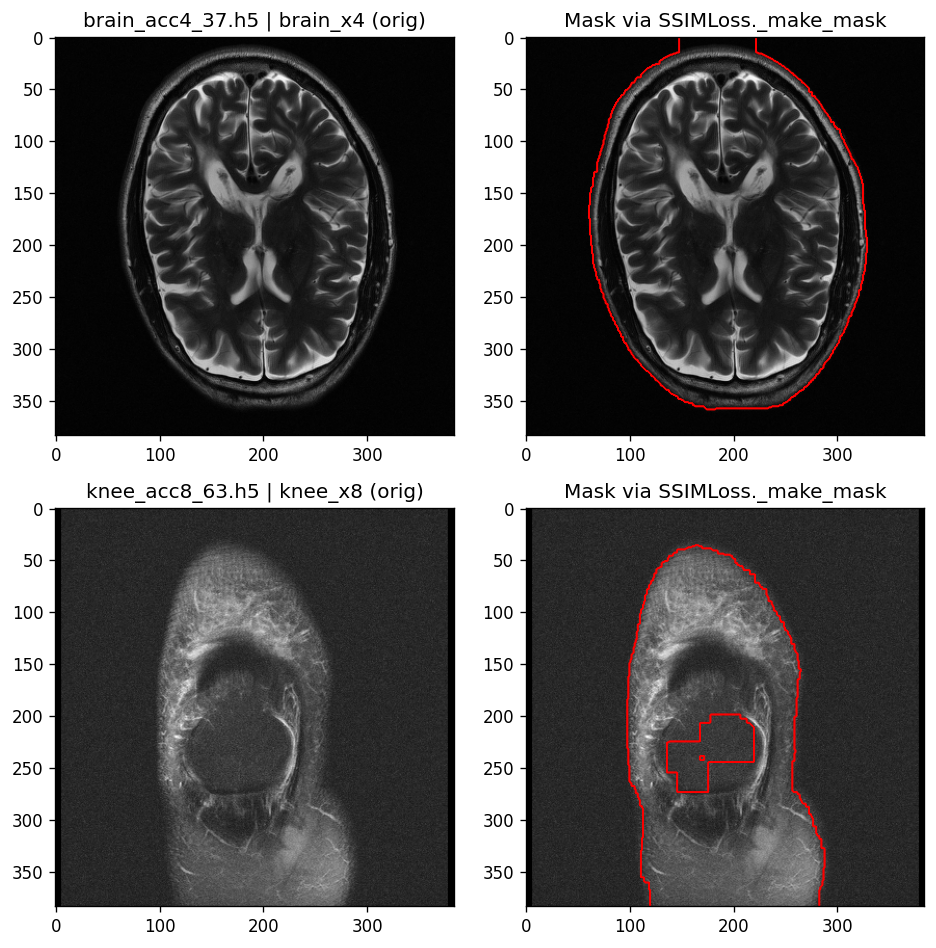

In [19]:
import cv2

def load_slice(h5_path, slice_idx=0):
    with h5py.File(h5_path, 'r') as f:
        vol = f['image_label'][:]      # (S, H, W)
    return vol[slice_idx]

fig, axes = plt.subplots(len(TEST_FILES), 2, figsize=(8, 4*len(TEST_FILES)))
for i, (cat, paths) in enumerate(TEST_FILES.items()):
    p = paths[0]
    slc = load_slice(p, 0)
    # to tensor batch
    tgt = torch.from_numpy(slc).to(device).unsqueeze(0)  # [1, H, W]
    mask = mask_loss._make_mask(tgt, [cat]).cpu().numpy()[0]

    ax1, ax2 = axes[i]
    ax1.imshow(slc, cmap='gray')
    ax1.set_title(f'{Path(p).name} | {cat} (orig)')
    ax2.imshow(slc, cmap='gray')
    ax2.contour(mask, colors='r', linewidths=0.5)
    ax2.set_title('Mask via SSIMLoss._make_mask')
plt.tight_layout()
plt.show()

4) Compare GRAPPA vs Label Loss Values

In [20]:
records = []
for cat, paths in TEST_FILES.items():
    for p in paths:
        with h5py.File(p, 'r') as f:
            lab = f['image_label'][0]      # (H, W)
            grp = f['image_grappa'][0]
            dr  = float(f.attrs['max'])

        # to tensor
        out = torch.from_numpy(grp).to(device)
        tgt = torch.from_numpy(lab).to(device)

        for name, L in losses.items():
            loss_val = L(out, tgt, dr, cats=cat).item()
            records.append({'file': Path(p).name,
                            'cat': cat,
                            'loss_type': name,
                            'loss_value': loss_val})

import pandas as pd

df = pd.DataFrame(records)
print(df.pivot(index=['file','cat'], columns='loss_type', values='loss_value'))

loss_type                        L1  MS-SSIM  MS-SSIM+L1        PSNR  \
file             cat                                                   
brain_acc4_37.h5 brain_x4  0.000006      0.0    0.000006  -99.880661   
knee_acc8_63.h5  knee_x8   0.000002      0.0    0.000002 -105.579453   

loss_type                      SSIM   SSIM+L1  
file             cat                           
brain_acc4_37.h5 brain_x4  0.052942  0.052948  
knee_acc8_63.h5  knee_x8   0.173355  0.173357  


5) Sample Masks for First 5 Volumes per Group

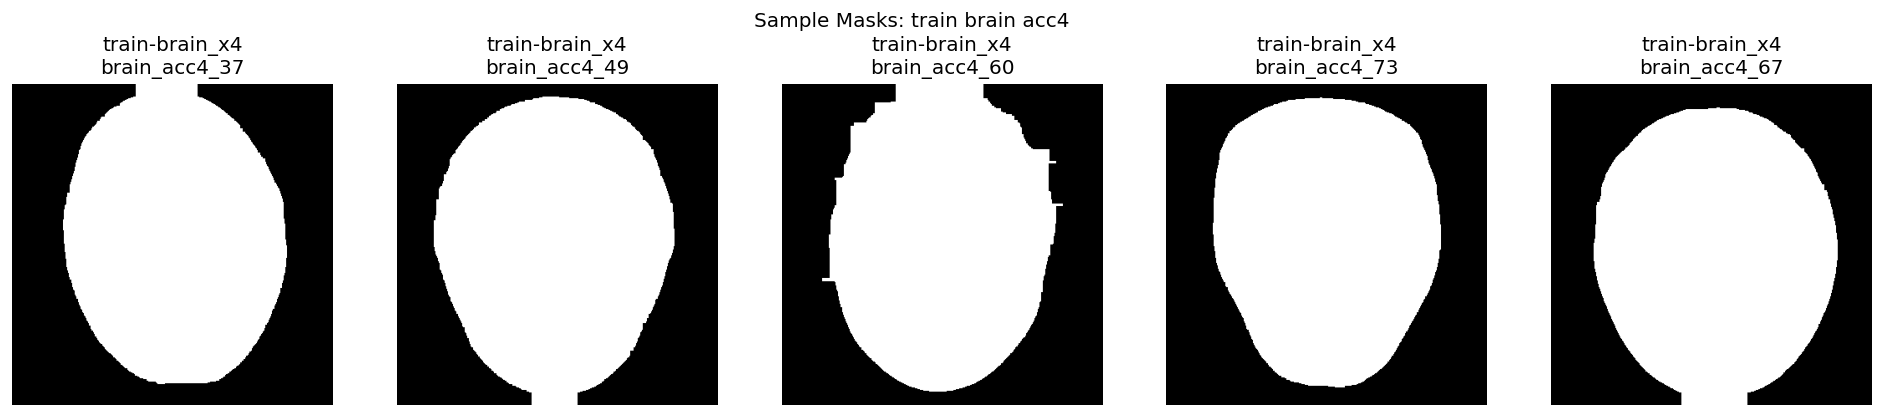

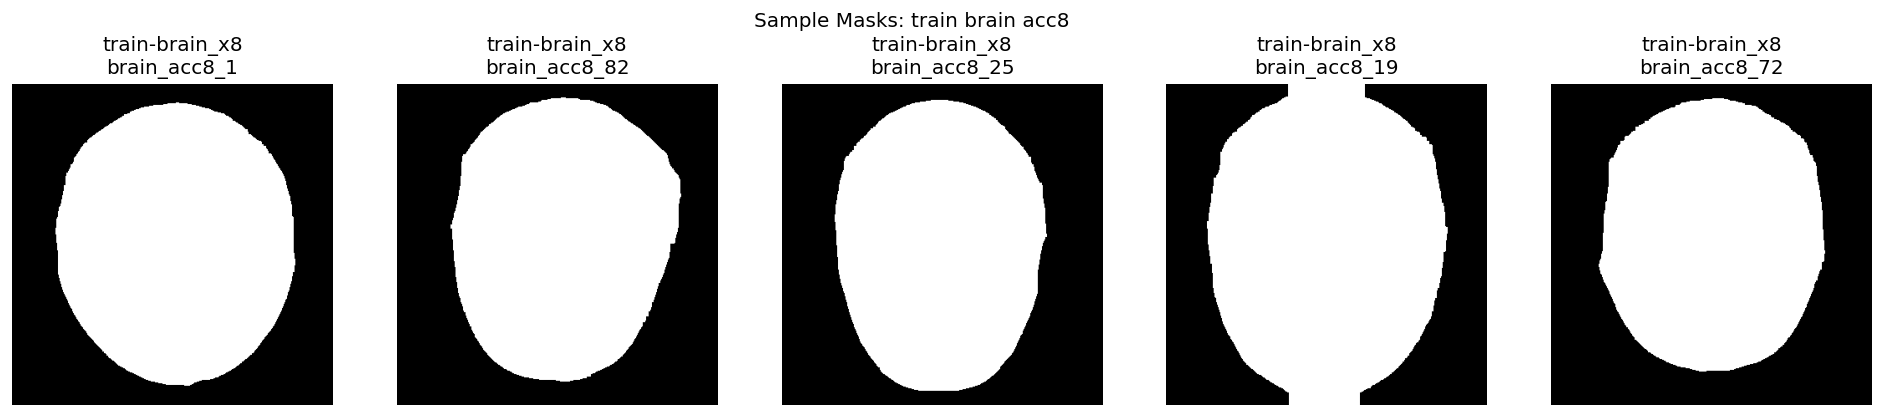

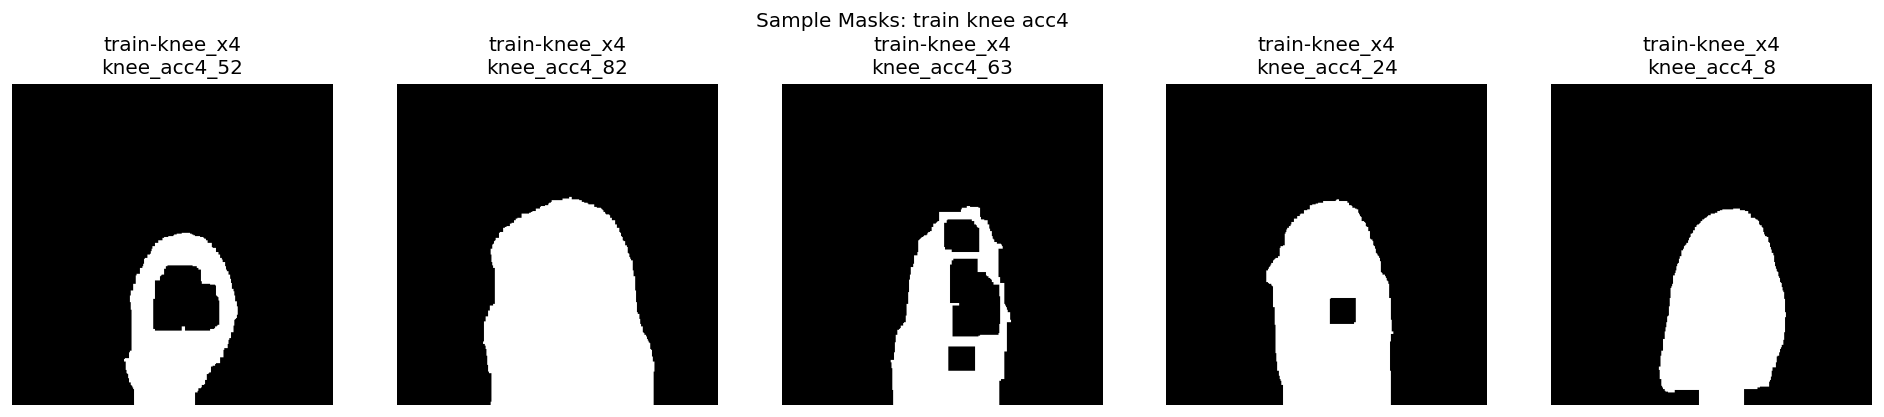

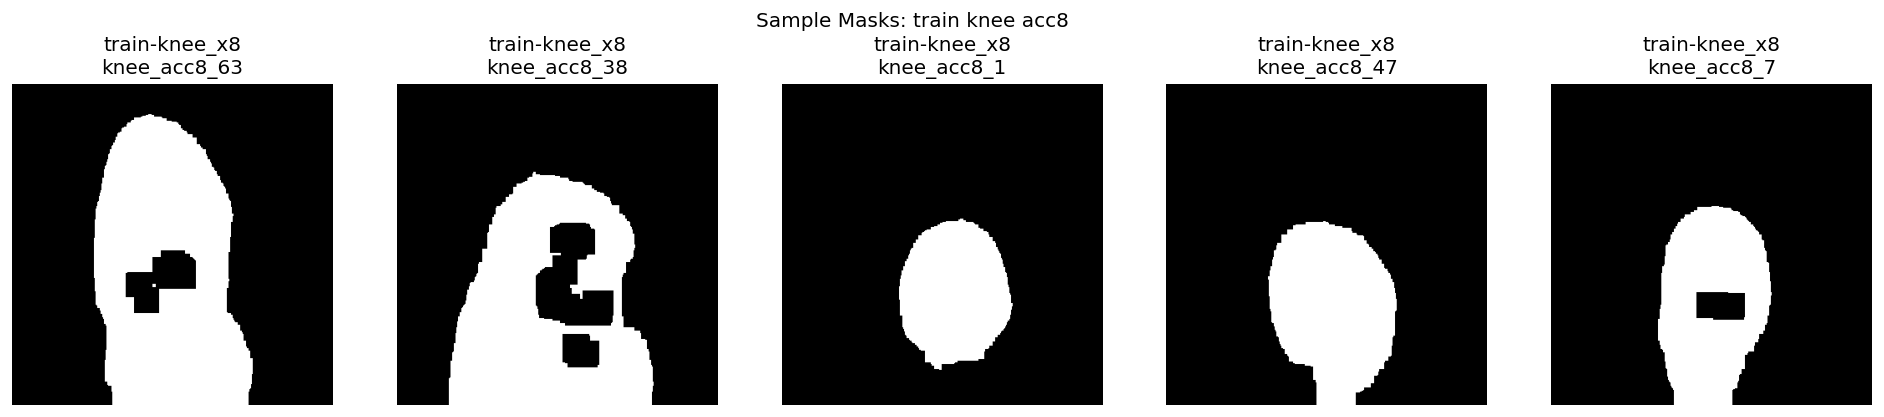

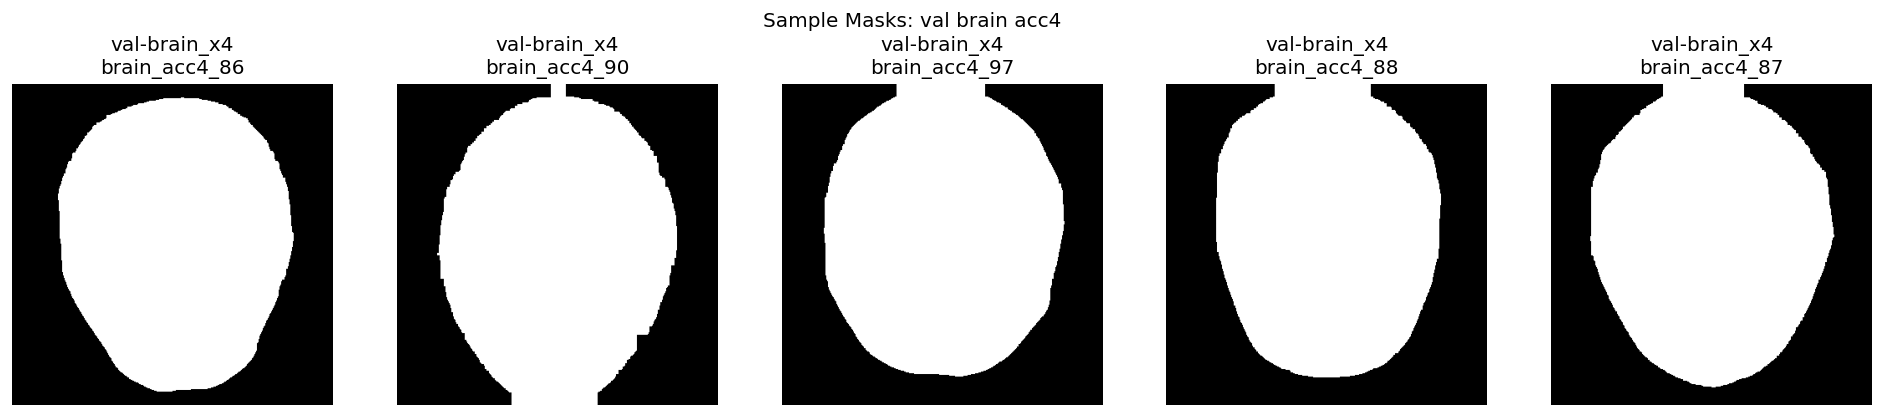

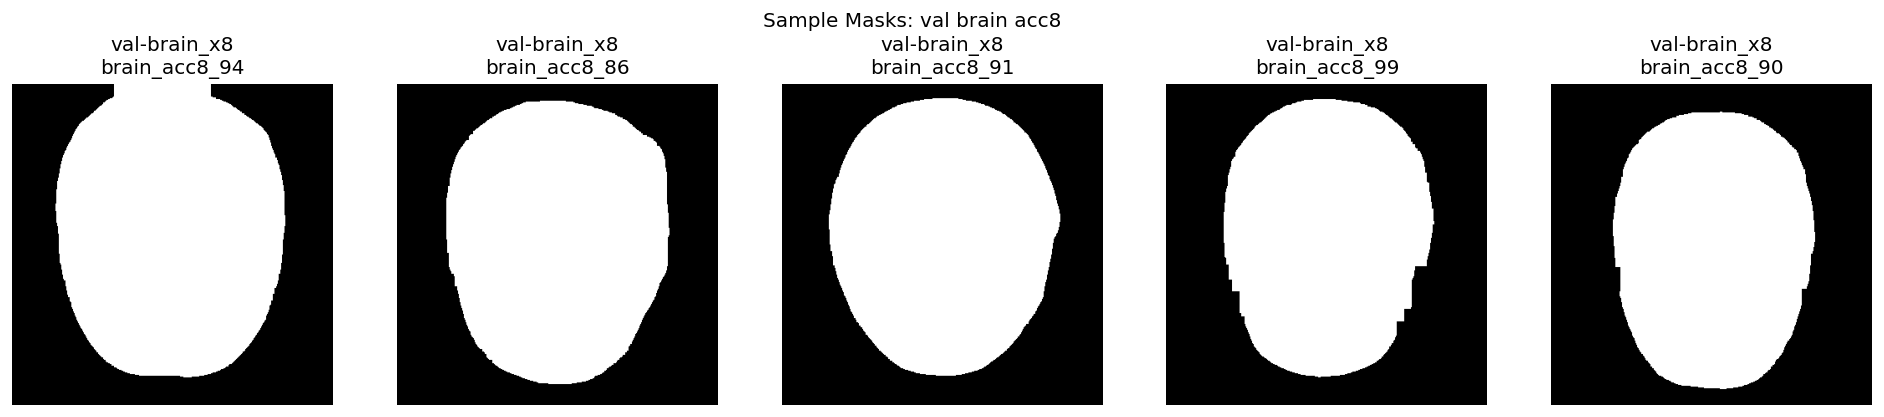

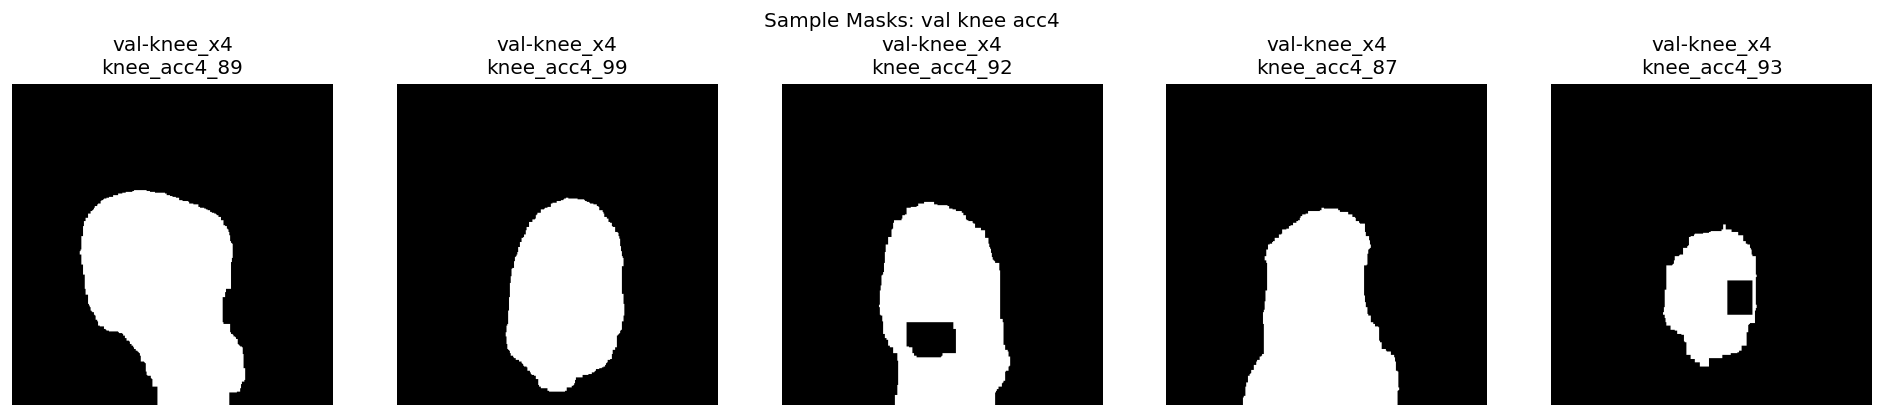

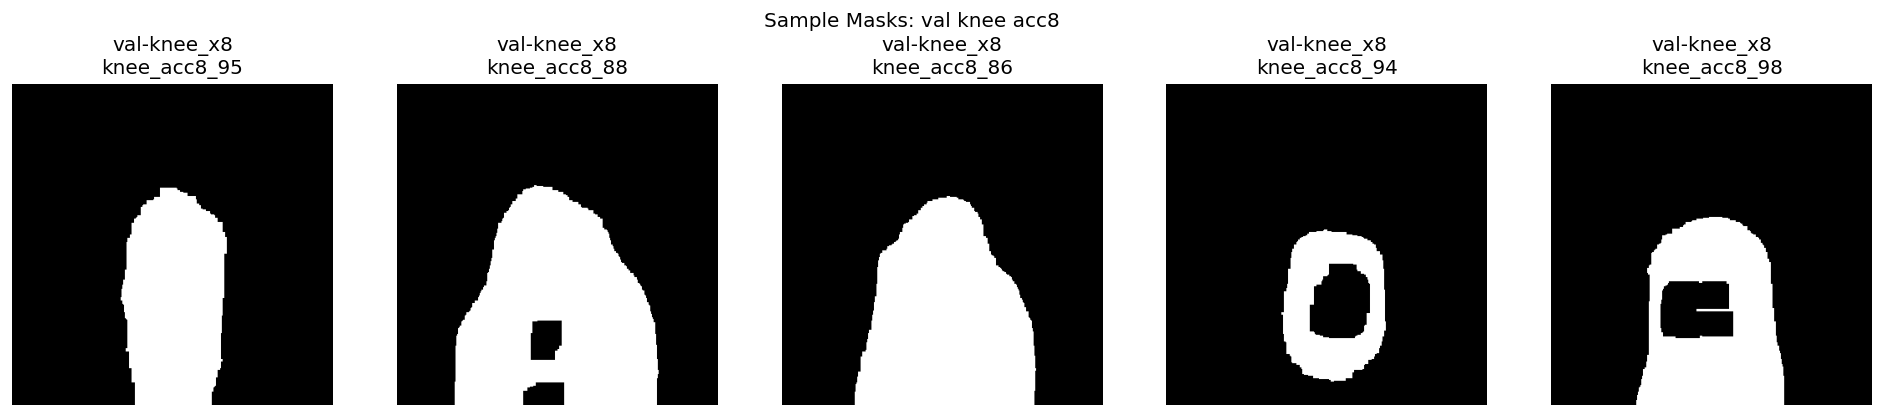

In [21]:
from collections import defaultdict

def list_volumes(split, body, acc):
    pattern = f"{body}_acc{acc}_*.h5"
    return glob.glob(os.path.join(DATA_DIR, split, 'image', pattern))

for split in ('train','val','leaderboard'):
    for body in ('brain','knee'):
        for acc in ('4','8'):
            files_ = list_volumes(split, body, acc)
            if not files_: continue
            # 첫 5 파일
            sel = files_[:5]
            fig, axes = plt.subplots(1, len(sel), figsize=(4*len(sel),4))
            for ax, p in zip(axes, sel):
                slc = load_slice(p,0)
                tgt = torch.from_numpy(slc).to(device).unsqueeze(0)
                mask = mask_loss._make_mask(tgt, [f'{body}_x{acc}']).cpu().numpy()[0]
                ax.imshow(mask, cmap='gray')
                ax.set_title(f'{split}-{body}_x{acc}\n{Path(p).stem}')
                ax.axis('off')
            plt.suptitle(f'Sample Masks: {split} {body} acc{acc}')
            plt.show()

6) Aggregated Mask Heatmap per (split, bo Notebook

train-brain_acc4:   0%|          | 0/85 [00:00<?, ?it/s]

train-brain_acc8:   0%|          | 0/85 [00:00<?, ?it/s]

train-knee_acc4:   0%|          | 0/85 [00:00<?, ?it/s]

train-knee_acc8:   0%|          | 0/85 [00:00<?, ?it/s]

val-brain_acc4:   0%|          | 0/15 [00:00<?, ?it/s]

val-brain_acc8:   0%|          | 0/15 [00:00<?, ?it/s]

val-knee_acc4:   0%|          | 0/15 [00:00<?, ?it/s]

val-knee_acc8:   0%|          | 0/15 [00:00<?, ?it/s]

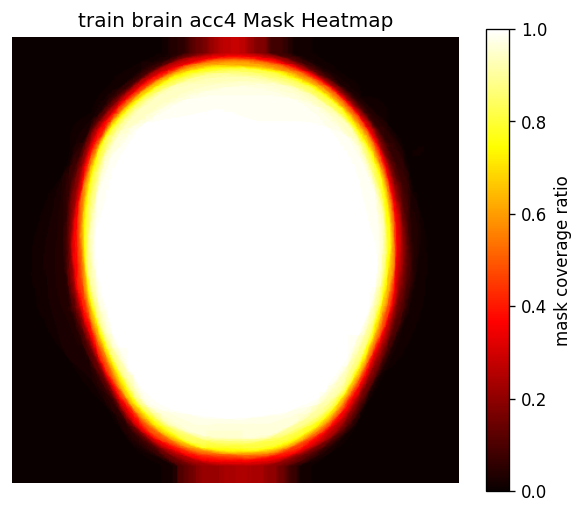

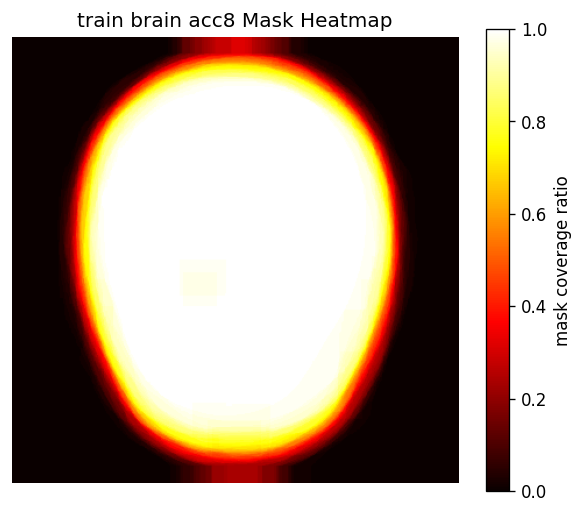

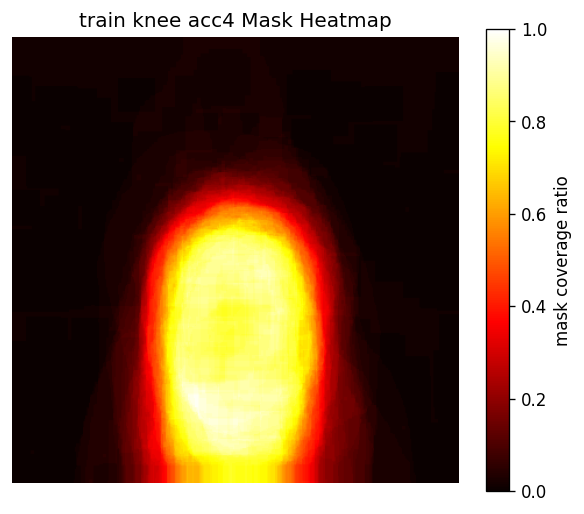

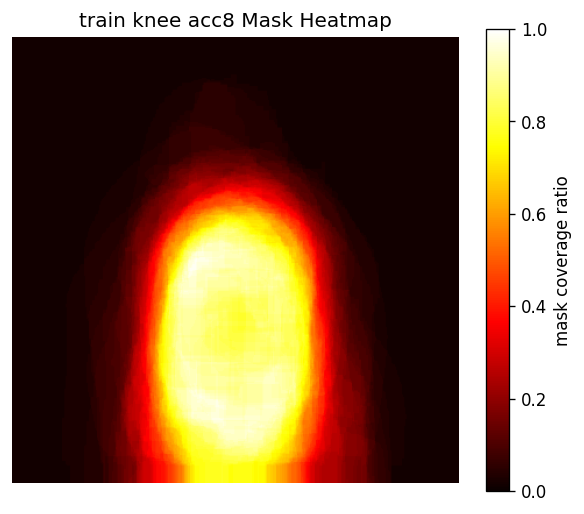

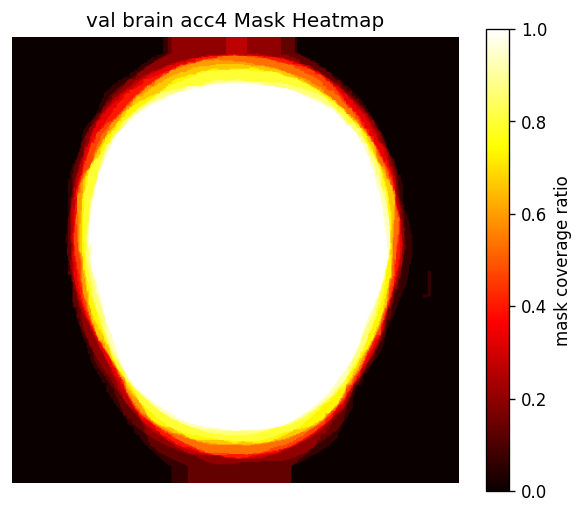

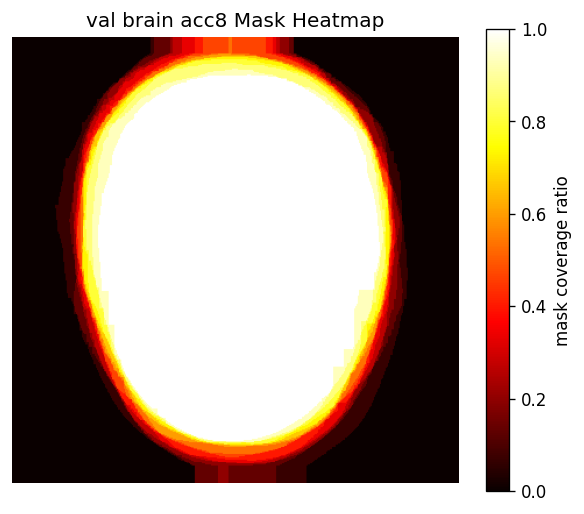

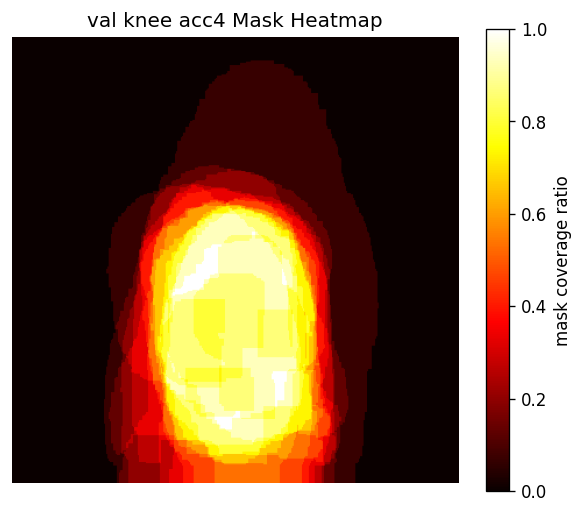

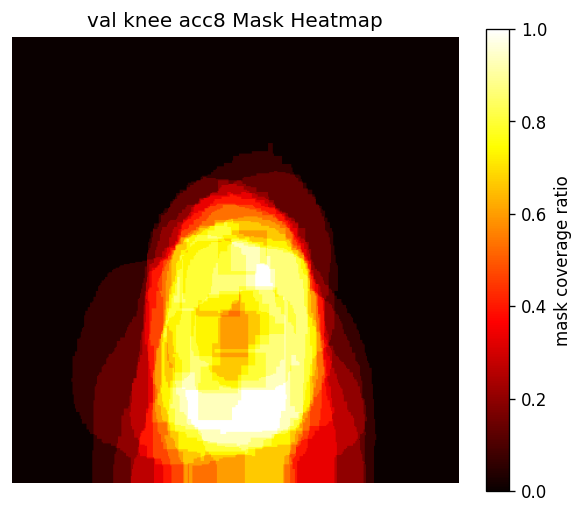

In [23]:
from collections import defaultdict
from tqdm.auto import tqdm

mask_stats = defaultdict(list)

for split in ('train','val','leaderboard'):
    for body in ('brain','knee'):
        for acc in ('4','8'):
            pats = list_volumes(split, body, acc)
            if not pats: continue
            for p in tqdm(pats, desc=f'{split}-{body}_acc{acc}'):
                slc = load_slice(p,0)
                tgt = torch.from_numpy(slc).to(device).unsqueeze(0)
                mask = mask_loss._make_mask(tgt, [f'{body}_x{acc}']).cpu().numpy()[0]
                mask_stats[(split, body, acc)].append(mask)

# 이제 아래 heatmap 생성 부분도 정상 동작합니다.
for (split, body, acc), masks in mask_stats.items():
    arr = np.stack(masks, axis=0).mean(axis=0)
    plt.figure(figsize=(6,5))
    plt.imshow(arr, cmap='hot', vmin=0, vmax=1)
    plt.colorbar(label='mask coverage ratio')
    plt.title(f'{split} {body} acc{acc} Mask Heatmap')
    plt.axis('off')
    plt.show()
